# Germ Selection
The purpose of this tutorial is to illustrate "germ selection".  Germ selection is the process by which a complete set of germ gate sequences is constructed.  The defining property which makes a set of gate sequences a "complete germ set" is the amplification of *all* possible gate errors.  More precisely, the repetition of a complete set of germs, sandwiched between preparation and measurement fiducial sequences, will yield a sensitivity to *all* gate errors that scales with the number of times each germ is repeated.  This completeness is relative to the set of gates under consideration, typically a set of desired or "target" gates.

In this tutorial, we find a complete germ set for the standard $X(\pi/2)$, $Y(\pi/2)$, $I$ gate set.

Before proceeding, however, we note the following:  This tutorial notebook is slightly different from others.  At present, germ selection is a bit of a "dark art".  While we have a simple function (pygsti.algorithms.germselection.test_germ_list_infl) for determining whether or not a germ set is "amplificationally complete" (AC), we do not at present have a method for *optimally* selecting such a set (in particular, selecting a set that is as small as possible).  This is in part because the germ list scoring function does a good job of distinguishing between AC and non-AC sets, it does less well distinguishing between sets that are both AC.

This notebook demonstrates how to generate an AC germ set, as well as demonstrating the functionality of several auxiliary functions we've developed to assist in the process.  However, it should not be taken as optimal; in particular, one may find better (smaller) AC germ sets by repeatedly running the germ selection function, seeded with an AC germ set plus a collection of further candidate germs, as demonstrated below.

For more details on the theory of germ selection, please see arXiv:1605.07674.

In [1]:
import pygsti
from pygsti.construction import std1Q_XYI as std
import time
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as _np

In [2]:
#A germ set is AC if and only if there are a number of non-zero eigenvalues (to machine precision) of J^\dagger J equal
#to the number of non-SPAM non-gauge parameters in a gate set, where J is the "twirled derivative" of the germ set with
#respect to the gate set.

#The gate set(s) we wish to test should have random unitary noise added to it, in order to break any accidental degeneracies.
#Additionally, even though experimental gate sets will have stochastic error,
#the gate set used for testing MUST have only unitary error, otherwise the selection procedure will fail.
#When actually running germ selection, the germ selection function can add random unitary noise; however,
#this does not automatically happen when calling test_germ_list_infl to test if a particular germ set is AC for a particular
#gate set.  Hence we manually randomize:

gs_real = std.gs_target.randomize_with_unitary(.1,seed=0)

#Let's see if a couple different germ sets are AC:

print "Is the standard germ set AC?", pygsti.algorithms.germselection.test_germ_list_infl(gs_real,std.germs)
print "Is the germ set {Gx, Gy, Gi} AC?", pygsti.algorithms.germselection.test_germ_list_infl(gs_real,pygsti.construction.gatestring_list([('Gx',),('Gy',),('Gi',)]))

Is the standard germ set AC? True
Is the germ set {Gx, Gy, Gi} AC? False


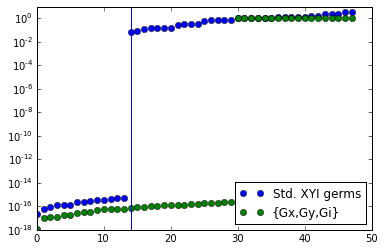

In [3]:
#Let's plot the sorted* eigenvalues of AC and non-AC germ sets.
#The horizontal line delineates gauge from non-gauge parameters.  We can never be sensitive to gauge parameters,
#but to be AC, we must be sensitive to all other parameters.

#*Due to numerical stability issues, some of the vanishingly small eigenvalues are negative;
#we plot their absolute values here.

plt.semilogy(sorted(_np.abs(pygsti.algorithms.germselection.test_germ_list_infl(gs_real,std.germs,returnSpectrum=True)[1])),'o',label='Std. XYI germs')
plt.semilogy(sorted(_np.abs(pygsti.algorithms.germselection.test_germ_list_infl(gs_real,pygsti.construction.gatestring_list([('Gx',),('Gy',),('Gi',)]),returnSpectrum=True)[1])),'o',label='{Gx,Gy,Gi}')
plt.axvline(pygsti.algorithms.germselection.num_non_spam_gauge_params(gs_real))
plt.legend(loc='best')

Let's now try to actually pick out a gate set.  The germ selection output will strongly depend on several different inputs to the function optimize_integer_germs_slack (argument name given in parenthesis):

1.  The gate set(s) to be optimized for.  (gatesetList)
2.  How strong the unitary randomization added is. (randomizationStrength; default is 1e-3.  Can be turned off by setting to 0 or by setting randomize=False; this should only be done if the input gate set(s) have already been subjected to some random unitary errors.
3.  How many different randomized instances of the input gate set to be tested (numCopies; only to be used if only one gate set is passed in.  The larger this number (or the larger the size of gatesetList), the more robust the output germ list will be in general, but the slower the runtime.
4.  How much adding a germ to the germ set "costs". (l1Penalty; default is 1e-2.  Increasing this *may* nudge the optimizer towards picking a smaller germ set.)
5.  How much making an individual germ longer "costs". (gatePenalty; default is 0.  Increasing this *may* nudge the optimizer towards picking a germ set with shorter germs.
6.  Whether the entire non-gauge portion of the spectrum to contributes to the germ score, or only the smallest eigenvalue.  (scoreFunc = 'all' or 'worst', respectively.)
7.  The relaxation scheme used to reduce the germ list size:

    7a.  The absolute score a germ set is allowed to achieve (fixedSlack) OR
    
    7b.  The relative score a germ set is allowed to achieve (slackFrac)
8.  Whether or not the germ set *must* contain each bare gate as a germ (forceSingletons)

The output should depend much more weakly (but not necessarily not at all) on the tolerance value (tol) passed to the optimizer.

Here we demonstrate particular choices for the above inputs.  However, we make no claims of optimality for these choices.  End users are encouraged to experiment themselves with these inputs.  They are also welcome to email pygsti@sandia.gov; the pyGSTi development team will try to assist.

The germ selection algorithm works by throwing unnecessary germs away from an initial (large) list that is assumed to be complete.  In this example, our initial list includes all gatestrings up to length six that are distinct up to powers and cycles.  Since germ sequences are repeated and sandwiched between fiducial sequences, a germ that is a power of another germ (i.e. the other germ repeated some number of times) or that is a cyclic permutation of another germ is effectively the same as the other germ.  (I.e., if Gx is included as a germ, then GxGx will not be.
Similarly, if GxGyGi is included as a germ, then GxiGxGy will not be.)
The `list_all_gatestrings_without_powers_and_cycles` function provides a convenient way to list sequences gate sequences that are distinct up to such powers and cycles. 

In [4]:
max_length = 6
gates = std.gs_target.gates.keys()

testGermList = pygsti.construction.list_all_gatestrings_without_powers_and_cycles(gates,max_length)

In [5]:
print "testGermList has", len(testGermList), "germs in it."
print "testGermList is", "not "*(1-pygsti.algorithms.germselection.test_germ_list_infl(gs_real,testGermList))+"AC."

testGermList has 196 germs in it.
testGermList is AC.


In [6]:
#Can we reduce the number of germs and still be AC?
#Let's start with:
#All 196 germs (germsList=testGermList, initialWeights=None),
#slackFrac=0.1, forceSingletons=True.
#Let's also try to score against 5 randomized gate sets (numCopies=5)

start = time.time()
germList1 = pygsti.algorithms.germselection.optimize_integer_germs_slack(std.gs_target,testGermList,numCopies=5,
                                                                         initialWeights=None,slackFrac=0.1,
                                                                         forceSingletons=True,
                                                                         maxIter=300,
                                                                         verbosity=2)
end = time.time()
print
print "Germ selection completed in", end-start, "seconds."
print "germList1 is", "not "*(1-pygsti.algorithms.germselection.test_germ_list_infl(gs_real,germList1))+"AC."

Complete initial germ set succeeds on all input gatesets.
Now searching for best germ set.
Starting germ set optimization. Lower score is better.
Gateset has 14 gauge params.
Iteration 0: score=11.3492, nGerms=196
Found better neighbor: nGerms = 195 score = 11.3463
Found better neighbor: nGerms = 195 score = 11.3455
Found better neighbor: nGerms = 195 score = 11.3452
Moving to better neighbor
Iteration 1: score=11.3452, nGerms=195
Found better neighbor: nGerms = 194 score = 11.3424
Found better neighbor: nGerms = 194 score = 11.3415
Moving to better neighbor
Iteration 2: score=11.3415, nGerms=194
Found better neighbor: nGerms = 193 score = 11.3387
Moving to better neighbor
Iteration 3: score=11.3387, nGerms=193
Found better neighbor: nGerms = 192 score = 11.3384
Found better neighbor: nGerms = 192 score = 11.3382
Found better neighbor: nGerms = 192 score = 11.3381
Found better neighbor: nGerms = 192 score = 11.3375
Moving to better neighbor
Iteration 4: score=11.3375, nGerms=192
Found 

In [7]:
#We have a germ set now!  Let's see what it looks like:
for germ in germList1:
    print germ

Gi
Gx
Gy
GiGxGyGyGiGy
GiGxGyGyGyGx
GiGyGiGyGxGy
GiGyGiGyGyGx
GiGyGxGyGxGy
GiGyGyGxGxGy
GiGyGyGyGxGx
GiGyGyGyGxGy
GxGxGyGyGxGy
GxGyGyGyGyGy


In [8]:
#Can we reduce this set in size and make some of the germs shorter by:
#1.  Adding extra random germs of varying lengths
#2.  Turning up the gatePenalty parameter
#3.  Relaxing slackFrac to 0.25?

testGermList1 = germList1 +\
                            pygsti.construction.list_random_gatestrings_onelen(std.gates,2,10,0)+\
                            pygsti.construction.list_random_gatestrings_onelen(std.gates,3,10,0)+\
                            pygsti.construction.list_random_gatestrings_onelen(std.gates,4,10,1)+\
                            pygsti.construction.list_random_gatestrings_onelen(std.gates,5,10,2)

testGermList1 = pygsti.listtools.remove_duplicates(testGermList1)

start = time.time()
germList2 = pygsti.algorithms.germselection.optimize_integer_germs_slack(std.gs_target,testGermList1,numCopies=5,
                                                                         initialWeights=None,slackFrac=0.25,
                                                                         gatePenalty = 1e0,
                                                                         forceSingletons=True,
                                                                         maxIter=300,
                                                                         verbosity=2)
end = time.time()
print
print "Germ selection completed in", end-start, "seconds."
print "germList2 is", "not "*(1-pygsti.algorithms.germselection.test_germ_list_infl(gs_real,germList1))+"AC."

Complete initial germ set succeeds on all input gatesets.
Now searching for best germ set.
Starting germ set optimization. Lower score is better.
Gateset has 14 gauge params.
Iteration 0: score=233.247, nGerms=46
Found better neighbor: nGerms = 45 score = 227.666
Found better neighbor: nGerms = 45 score = 227.478
Found better neighbor: nGerms = 45 score = 227.328
Moving to better neighbor
Iteration 1: score=227.328, nGerms=45
Found better neighbor: nGerms = 44 score = 221.748
Found better neighbor: nGerms = 44 score = 221.561
Found better neighbor: nGerms = 44 score = 221.413
Moving to better neighbor
Iteration 2: score=221.413, nGerms=44
Found better neighbor: nGerms = 43 score = 215.833
Found better neighbor: nGerms = 43 score = 215.647
Moving to better neighbor
Iteration 3: score=215.647, nGerms=43
Found better neighbor: nGerms = 42 score = 210.072
Moving to better neighbor
Iteration 4: score=210.072, nGerms=42
Found better neighbor: nGerms = 41 score = 209.755
Found better neighbor

In [9]:
for germ in germList2:
    print germ

Gi
Gx
Gy
GiGyGyGxGxGy
GiGyGyGyGxGx
GxGxGyGyGxGy
GiGiGy
GyGxGy
GxGyGiGi
GiGiGiGx
GiGyGiGx


In [10]:
#Success!  Let's see if this germ set is AC for a bunch of random gate sets:

num_fails = 0
for i in xrange(100):
    if not pygsti.alg.germselection.test_germ_list_infl(std.gs_target.randomize_with_unitary(0.01,i),germList2):
        num_fails += 1
print 'Germ set fails on', num_fails, 'gate sets out of 100.'

Germ set fails on 0 gate sets out of 100.


In [11]:
#Success!  We've selected a single-qubit germ set that has only 11 germs and is robust against noise.
#Further testing is possible by simulating GST data on a unitarily noisy gate set using these germs, and
#examinining whether or not 1/L scaling is achieved.

#Also, you can write your newfound germs to file:  
#pygsti.io.write_gatestring_list("mygerms.lst",germList2,"List of germs from tutorial")